In [ ]:
import numpy as np  # Processamento numérico e manipulação de arrays
import pandas as pd  # Manipulação e análise de dados (DataFrames)
import matplotlib.pyplot as plt  # Criação de gráficos e visualizações
import random as python_random  # Geração de números aleatórios nativos
import tensorflow as tf  # Framework para criação e treino das LSTMs
import keras_tuner as kt  # Otimização automática de hiperparâmetros
import sys  # Interação com o sistema e caminhos do Python
import importlib  # usada para interagir com o sistema de importação
import utils  # arquivo local utils.py
from pathlib import Path  # Manipulação de caminhos de diretórios
from keras.callbacks import EarlyStopping  # Evita o overfitting no treino
from sklearn.preprocessing import MinMaxScaler  # Normalização dos dados
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)  # Métricas

# Define o caminho raiz do projeto (diretório pai)
root_path = str(Path.cwd().parent)

# Adiciona o caminho raiz ao sistema para permitir importações locais
if root_path not in sys.path:
    sys.path.append(root_path)

# Importa funções customizadas do utils.py (Ignora erro E402 do Flake8)
from utils import criar_sequencias  # noqa: E402
from utils import construcao_modelo  # noqa: E402

# Configura o Pandas para exibir todas as colunas sem ocultá-las
pd.set_option("display.max_columns", None)

In [148]:
# Carrega os dados a partir de um arquivo Parquet (formato otimizado)
df_model = pd.read_parquet("../arquivos_parquet/dados_base.parquet")

# Ordena o índice cronologicamente para garantir a sequência temporal
df_model = df_model.sort_index(ascending=True)

# Seleciona colunas de Preço e Volatilidade para a LSTM multivariada
df_model_LSTM = df_model[["Close", "Var%"]]

# Exibe a estrutura final para validação das features
df_model_LSTM

,Close,Var%
Date,,
2023-01-02,14.359387,0.000000
2023-01-03,14.084920,-1.911415
2023-01-04,14.098303,0.095016
2023-01-05,14.513354,2.943982
2023-01-06,14.700801,1.291546
...,...,...
2026-02-09,44.750000,3.015657
2026-02-10,44.889999,0.312848
2026-02-11,45.730000,1.871241


In [149]:
# Valor da semente para garantir resultados reproduzíveis
seed_value = 42

# Janela de 15 dias de histórico para prever o próximo ponto
WINDOW_SIZE = 15

# Configura semente para o gerador aleatório nativo do Python
python_random.seed(seed_value)

# Configura semente para o NumPy (consistência em arrays)
np.random.seed(seed_value)

# Configura semente para o TensorFlow (pesos da LSTM)
tf.random.set_seed(seed_value)

In [150]:
# Calcula o índice para separar 80% dos dados para treinamento
split_idx = int(len(df_model_LSTM) * 0.8)

# Define o conjunto de treino com os primeiros 80% dos dados
train_df = df_model_LSTM.iloc[:split_idx]

# Define o conjunto de teste com os 20% finais (dados recentes)
test_df = df_model_LSTM.iloc[split_idx:]

In [151]:
# Inicializa o escalonador para normalizar os dados entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajusta o scaler ao treino e transforma os dados (fit_transform)
train_scaled = scaler.fit_transform(train_df)

# Aplica a mesma escala aos dados de teste (apenas transform)
test_scaled = scaler.transform(test_df)

In [152]:
# Gera sequências de treino usando a janela de 15 dias
X_train, y_train = criar_sequencias(train_scaled, WINDOW_SIZE)

# Gera sequências de teste mantendo a mesma lógica de janela
X_test, y_test = criar_sequencias(test_scaled, WINDOW_SIZE)

In [153]:
# Exibe as dimensões dos arrays de treino para conferência técnica
print(f"Formato dos dados de treino: {X_train.shape}")

# Exibe as dimensões dos arrays de teste para validar a consistência
print(f"Formato dos dados de teste: {X_test.shape}")

Formato dos dados de treino: (609, 15, 2)
Formato dos dados de teste: (141, 15, 2)


In [154]:
# Configura interrupção precoce para evitar overfitting no treino
early_stop = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Inicializa o Tuner Hyperband para busca de hiperparâmetros
tuner = kt.Hyperband(
    construcao_modelo,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="tuner_results",
    project_name="itub3_optimization",
)

# Inicia a busca automática pelas melhores configurações da rede
tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
)

# Recupera os melhores parâmetros encontrados durante a busca
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Constrói o modelo final otimizado com os melhores parâmetros
model = tuner.hypermodel.build(best_hps)

Reloading Tuner from tuner_results\itub3_optimization\tuner0.json


In [155]:
# Exibe a arquitetura detalhada e o total de parâmetros do modelo final
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 15, 96)         │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 15, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 25)             │         2,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,579 (447.57 KB)

 Trainable params: 114,579 (447.57 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
# Realiza o treinamento final do modelo com os melhores hiperparâmetros
model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0362 - mae: 0.2025 - mse: 0.0724 - val_loss: 0.1088 - val_mae: 0.4393 - val_mse: 0.2176
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0036 - mae: 0.0670 - mse: 0.0071 - val_loss: 0.0214 - val_mae: 0.1675 - val_mse: 0.0429
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - mae: 0.0461 - mse: 0.0036 - val_loss: 0.0119 - val_mae: 0.1032 - val_mse: 0.0237
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - mae: 0.0421 - mse: 0.0031 - val_loss: 0.0164 - val_mae: 0.1385 - val_mse: 0.0327
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - mae: 0.0466 - mse: 0.0039 - val_loss: 0.0149 - val_mae: 0.1318 - val_mse: 0.0299
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015 - mae: 0.0411 - mse: 0.0030 - val_loss: 0.0065 - val_mae: 0.0734 - val_mse: 0.0131
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - mae: 0.0387 - mse: 0.0028 - val

In [157]:
# Realiza a previsão do preço usando os dados de teste escalonados
y_pred = model.predict(X_test)

# Cria matrizes vazias para reverter a escala (formato original de 2 colunas)
y_test_unscaled = np.zeros((len(y_test), 2))
y_pred_unscaled = np.zeros((len(y_pred), 2))

# Preenche a primeira coluna com os dados escalonados (Preço de Fechamento)
y_test_unscaled[:, 0] = y_test
y_pred_unscaled[:, 0] = y_pred.flatten()

# Inverte a normalização para obter os preços reais de teste
y_test_final = scaler.inverse_transform(y_test_unscaled)[:, 0]

# Inverte a normalização para obter os preços reais previstos
y_pred_final = scaler.inverse_transform(y_pred_unscaled)[:, 0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


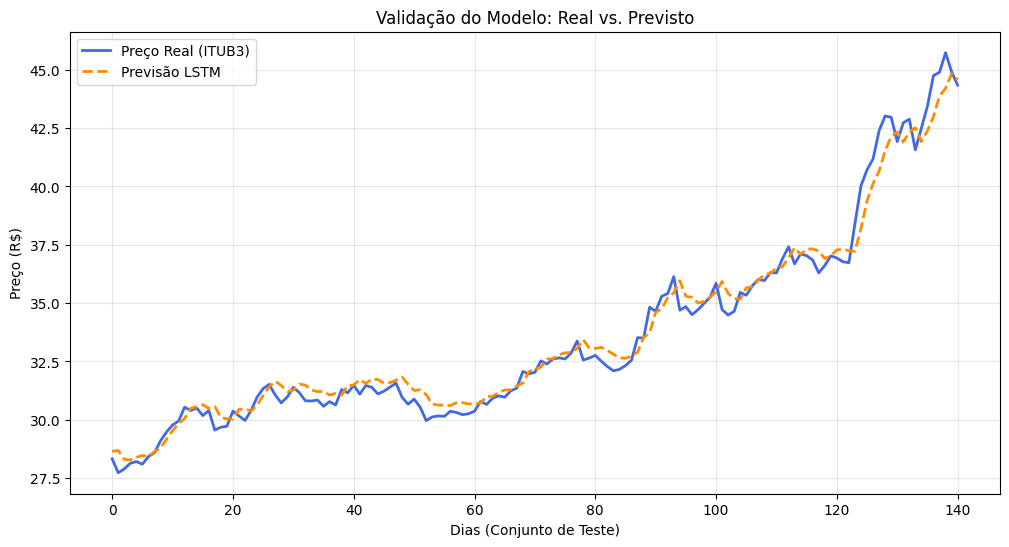

In [158]:
# Define o tamanho da figura para uma visualização clara do gráfico
plt.figure(figsize=(12, 6))

# Plota os preços reais do ITUB3 em azul
plt.plot(
    y_test_final, label="Preço Real (ITUB3)", color="royalblue", linewidth=2
)

# Plota as previsões da LSTM em laranja com linha tracejada
plt.plot(
    y_pred_final,
    label="Previsão LSTM",
    color="darkorange",
    linestyle="--",
    linewidth=2,
)

# Configura título e rótulos dos eixos do gráfico
plt.title("Validação do Modelo: Real vs. Previsto")
plt.xlabel("Dias (Conjunto de Teste)")
plt.ylabel("Preço (R$)")

# Adiciona legenda e grade para facilitar a leitura técnica
plt.legend()
plt.grid(True, alpha=0.3)

# Exibe o gráfico final de performance
plt.show()

In [159]:
# Calcula o Erro Médio Absoluto em Reais (R$)
mae = mean_absolute_error(y_test_final, y_pred_final)

# Calcula a Raiz do Erro Quadrático Médio (estabilidade)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calcula o Erro Médio Percentual Absoluto (MAPE)
mape = np.mean(np.abs((y_test_final - y_pred_final) / y_test_final)) * 100

# Calcula o R2 (Quanto da variação o modelo explica)
r2 = r2_score(y_test_final, y_pred_final)

# Calcula o WMAPE (Erro percentual ponderado pelo valor real)
wmape = (
    np.sum(np.abs(y_test_final - y_pred_final)) / np.sum(y_test_final) * 100
)

# Exibe as métricas formatadas para o relatório técnico
print(f"MAE: R$ {mae:.2f}")
print(f"RMSE: R$ {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")
print(f"WMAPE: {wmape:.2f}%")

MAE: R$ 0.46
RMSE: R$ 0.60
MAPE: 1.33%
R2 Score: 0.9801
WMAPE: 1.36%


In [160]:
# Obtém a última janela de 15 dias do teste para iniciar a previsão
last_window = test_scaled[-WINDOW_SIZE:].copy()

# Redimensiona para o formato (1, 15, 2) aceito pela entrada da LSTM
current_batch = last_window.reshape((1, WINDOW_SIZE, 2))

# Inicializa a lista que armazenará as previsões para os próximos 5 dias
forecast_5d = []

In [161]:
# Obtém a última data do dataset para iniciar a contagem futura
ultima_data = df_model_LSTM.index.max()

# Cria o intervalo de datas para os próximos 5 dias úteis (B = Business)
datas_projecao = pd.date_range(
    start=ultima_data + pd.Timedelta(days=1), periods=5, freq="B"
)

# Loop recursivo: cada previsão alimenta a próxima entrada do modelo
for _ in range(5):
    # Realiza a predição para o próximo passo no horizonte temporal
    current_pred = model.predict(current_batch, verbose=0)[0]
    forecast_5d.append(current_pred)

    # Extrai o último preço e a nova predição para calcular a variação
    last_price = current_batch[0, -1, 0]
    new_price = current_pred[0]

    # Calcula a Var% prevista para manter a estrutura multivariada
    new_var = (new_price - last_price) / last_price if last_price != 0 else 0

    # Monta a nova entrada e atualiza a janela (desliza o histórico)
    new_entry = np.array([new_price, new_var]).reshape(1, 1, 2)
    current_batch = np.append(current_batch[:, 1:, :], new_entry, axis=1)

# Prepara matriz para reverter a escala das previsões futuras
forecast_unscaled = np.zeros((5, 2))
forecast_unscaled[:, 0] = np.array(forecast_5d).flatten()
forecast_final = scaler.inverse_transform(forecast_unscaled)[:, 0]

# Exibe o cabeçalho do relatório de projeção de preços
print(
    f"Projeção ITUB3 para os próximos 5 dias úteis "
    f"(Iniciando em {datas_projecao[0].strftime('%d/%m/%Y')}):"
)
print("-" * 50)

# Imprime cada data futura com seu respectivo preço previsto em Reais
for data, preco in zip(datas_projecao, forecast_final):
    print(
        f"{data.strftime('%d/%m/%Y')} ({data.strftime('%a')}): R$ {preco:.2f}"
    )
print("-" * 50)

Projeção ITUB3 para os próximos 5 dias úteis (Iniciando em 16/02/2026):
--------------------------------------------------
16/02/2026 (Mon): R$ 44.30
17/02/2026 (Tue): R$ 43.54
18/02/2026 (Wed): R$ 42.72
19/02/2026 (Thu): R$ 41.92
20/02/2026 (Fri): R$ 41.14
--------------------------------------------------


In [ ]:
# Recarrega o modulo utils para aplicar alteracoes feitas no arquivo .py
importlib.reload(utils)

# Exibe o caminho do arquivo carregado para confirmar a origem (raiz)
print(f"Modulo carregado de: {utils.__file__}")

# Exporta os artefatos (modelo e scaler) usando a lógica de Path do utils
utils.exportar_modelo_itub3(model, scaler, version="v2")

c:\Users\Pc Gamer\OneDrive\FIAP\Machine Learnig Engineering\Fase - 04\fiap_tech_challenge_fase4_V2\utils.py
Salvando em: C:\Users\Pc Gamer\OneDrive\FIAP\Machine Learnig Engineering\Fase - 04\fiap_tech_challenge_fase4_V2\models\itub3_lstm_v2.h5
Salvando em: C:\Users\Pc Gamer\OneDrive\FIAP\Machine Learnig Engineering\Fase - 04\fiap_tech_challenge_fase4_V2\models\scaler_itub3_v2.pkl
